<a href="https://colab.research.google.com/github/laurence-lin/Kaggle_competition/blob/master/SantanderTransactionPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, train_test_split
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score


import os
import gc
import time

print('Library imported. ')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Library imported. 


In [ ]:
from google.colab import files

files.upload() # upload kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!kaggle competitions download -c 'santander-customer-transaction-prediction'
!unzip train.csv.zip
!unzip test.csv.zip
!unzip sample_submission.csv.zip

Saving kaggle.json to kaggle.json
 94% 117M/125M [00:02<00:00, 35.8MB/s]
100% 125M/125M [00:02<00:00, 60.2MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 144MB/s]
 90% 113M/125M [00:02<00:00, 38.4MB/s]
100% 125M/125M [00:02<00:00, 59.0MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gc.collect()

print('Train size:', train.shape)
print('Test size:', test.shape)


Train size: (200000, 202)
Test size: (200000, 201)


In [ ]:
%%time
train.describe()

CPU times: user 1.78 s, sys: 79 ms, total: 1.86 s
Wall time: 1.87 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2000

In [ ]:
%%time
test.describe()

CPU times: user 1.79 s, sys: 4.8 ms, total: 1.8 s
Wall time: 1.81 s


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000

In [ ]:
print(train[::20].shape)
print(train[::20])


(10000, 202)
             ID_code  target    var_0   var_1    var_2   var_3    var_4  \
0            train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607   
20          train_20       0  12.6700 -2.0221   6.8930  6.9152   9.5677   
40          train_40       0  11.4653  1.3359   9.6714  9.0111  12.5167   
60          train_60       0   5.7733  0.6536   9.3862  6.2292   9.5133   
80          train_80       0   8.7099 -5.1212  10.8110  6.6057  10.4421   
...              ...     ...      ...     ...      ...     ...      ...   
199900  train_199900       0  12.8486 -5.9865   9.9833  9.0730  11.5139   
199920  train_199920       0  12.3430  6.7949   8.0519  9.8975   9.6292   
199940  train_199940       0  15.7467 -2.2938  11.9918  8.3530   8.8658   
199960  train_199960       0   7.4548 -8.6373   6.8615  6.3426   9.7905   
199980  train_199980       0   7.9618  6.2271  13.3326  7.5345  12.5645   

          var_5   var_6    var_7   var_8   var_9   var_10  var_11   var_12  \
0       

0    179902
1     20098
Name: target, dtype: int64


Text(0, 0.5, 'Counts')

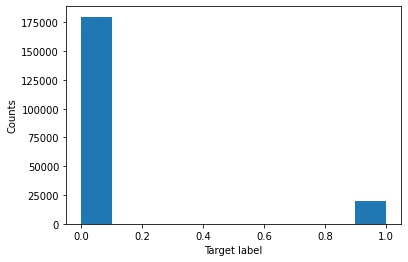

In [ ]:
print(train['target'].value_counts())
plt.hist(train['target'])
plt.xlabel('Target label')
plt.ylabel('Counts')

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, log_loss, accuracy_score

print('Models imported.')
print('Metrics imported.')


Models imported.
Metrics imported.


In [ ]:
# subsampling

train_pos = train[train['target'] == 1]
train_neg = train[train['target'] == 0]

pos = train_pos.sample(1000)
neg = train_neg.sample(9000)

df_sub = pd.concat([pos, neg], axis = 0)
print(df_sub.shape)

y_sub = df_sub['target']
x_sub = df_sub.drop(['target', 'ID_code'], axis = 1)
x_train, x_valid, y_train, y_valid = train_test_split(x_sub, y_sub, test_size = 0.2, stratify = y_sub)
print(train['target'].value_counts())
print(y_sub.value_counts())

(10000, 202)
0    179902
1     20098
Name: target, dtype: int64
0    9000
1    1000
Name: target, dtype: int64


###See base model peroformance before feature engineering.

In [ ]:

logit = RidgeClassifierCV(cv = 5)
svm = SVC(kernel = 'rbf', C = 0.01)
tree = DecisionTreeClassifier(max_depth = 25)
forest = RandomForestClassifier(n_estimators=40, max_depth = 25)

models = {'Logistic':logit, 'SVM':svm, 'DecisionTree':tree, 'RandomForest':forest}


for model in models: # keys in dict
    
    print(model)
    model = models[model]
    model.fit(x_train, y_train)

    y_predict = model.predict(x_train)
    roc_score = roc_auc_score(y_train, y_predict)
    print('Training ROC AUC: ', roc_score)

    y_predict = model.predict(x_valid)
    roc_score = roc_auc_score(y_valid, y_predict)
    print('ROC AUC: ', roc_score)



Logistic
Training ROC AUC:  0.5209722222222223
ROC AUC:  0.5069444444444444
SVM
Training ROC AUC:  0.5
ROC AUC:  0.5
DecisionTree
Training ROC AUC:  0.935
ROC AUC:  0.5372222222222222
RandomForest
Training ROC AUC:  0.90375
ROC AUC:  0.5


###Perform poor on subset. For too much features, try feature selection.

---



(10000, 200)
(200,)


"\nfor thr in threshold:\n    select = VarianceThreshold(thr)\n    x_train_ = select.fit_transform(x_train)\n    x_valid_ = select.transform(x_valid)\n    \n    model.fit(x_train_, y_train)\n    y_pred = model.predict(x_valid_)\n    score = roc_auc_score(y_valid, y_pred)\n    print('Score under variance threshold: {} is {}'.format(thr, score))\n\n"

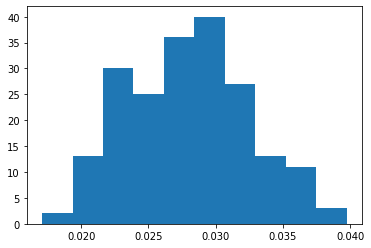

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest

# Try variance threshold filtering
scaler = MinMaxScaler()
x_sub = scaler.fit_transform(x_sub)
print(x_sub.shape)
x_var = np.var(x_sub, axis = 0)
print(x_var.shape)

plt.hist(x_var)


threshold = [0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.025]

x_train, x_valid, y_train, y_valid = train_test_split(x_sub, y_sub, test_size = 0.2, stratify = y_sub)
'''
for thr in threshold:
    select = VarianceThreshold(thr)
    x_train_ = select.fit_transform(x_train)
    x_valid_ = select.transform(x_valid)
    
    model.fit(x_train_, y_train)
    y_pred = model.predict(x_valid_)
    score = roc_auc_score(y_valid, y_pred)
    print('Score under variance threshold: {} is {}'.format(thr, score))

'''
# variance threshold shows no improvement

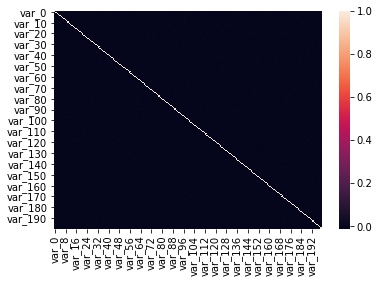

In [ ]:
# feature selection: compute correlation

x_ = train.drop(['ID_code', 'target'], axis = 1)
ind = x_.index
col = x_.columns
scaler = MinMaxScaler()
x_ = scaler.fit_transform(x_)
x_ = pd.DataFrame(data = x_, columns = col, index = ind)
corr = x_.corr()

sns.heatmap(corr)

In [ ]:
x_train.shape

(8000, 200)

###Features are all poorly correlated to each other, it's hard to select feature by correlation.

In [ ]:
from sklearn.feature_selection import SelectKBest, RFECV, f_classif
from scipy.stats import shapiro, probplot, normaltest, f_oneway

# ANOVA F-test
# First test data normality

for i in range(x_train.shape[1]):
  w, p = shapiro(x_train[:, i])
  
  if p < 0.05:
    pass
    #print('Feature {} is non-normal distributed'.format(i + 1))
  elif p > 0.05:
    print('Feature {} is normally distributed'.format(i + 1))
    

# Assume feature is all normally distributed, start ANOVA F test




selector = SelectKBest(f_classif, k = 130) # select 100 features with largest F-value
xf_train = selector.fit_transform(x_train, y_train)
xf_test = selector.transform(x_valid)

#model = DecisionTreeClassifier(max_depth= 25)
model = SVC(kernel = 'rbf', C = 1.2)
model.fit(xf_train, y_train)
y_pred = model.predict(xf_test)
score = roc_auc_score(y_valid, y_pred)
print('AUC score after F test: ', score)


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


AUC score after F test:  0.5602777777777778


###F test slightly improve the performance, now apply recursive feature selection

In [ ]:
from sklearn.feature_selection import RFECV


#model = SVC(kernel = 'rbf', C = 1.2)
model = DecisionTreeClassifier(max_depth= 25)
selector = RFECV(estimator = model, step = 1, min_features_to_select=1, cv = 2,
                 scoring = 'roc_auc',
                 verbose = 1)

selector.fit(xf_train, y_train)
print('Optimal number of features:', selector.n_features_)


Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
F

In [ ]:
# Reduce the features selected by RFECV

xrf_train = selector.transform(xf_train)
xrf_valid = selector.transform(xf_test)

model = DecisionTreeClassifier(max_depth = 25)
model.fit(xrf_train, y_train)
y_pred = model.predict(xrf_valid)
score = roc_auc_score(y_valid, y_pred)
print('AUC after RFECV:', score)


AUC after RFECV: 0.5511111111111111


In [ ]:
# Select by Model

#model = SVC(kernel = 'linear', C = 0.1)
model = LogisticRegression(penalty = 'l1', C = 1, solver = 'saga')
selector = SelectFromModel(estimator = model)

x_new = selector.fit_transform(x_train, y_train)
print('After select by model:', x_new.shape)

model = SVC(kernel = 'rbf', C = 5, gamma = 'scale')
model.fit(x_new, y_train)
x_ = selector.transform(x_valid)
y_pred = model.predict(x_)
score = roc_auc_score(y_valid, y_pred)
print('AUC after Select by Model', score)


After select by model: (8000, 191)
AUC after Select by Model 0.6091666666666666


In [ ]:
# PCA
from sklearn.decomposition import PCA

n_compo = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180]

for n in n_compo:
    pca = PCA(n)
    x_pca = pca.fit_transform(x_new)
 
    model = SVC(kernel = 'rbf', C = 5, gamma = 'scale')
    model.fit(x_pca, y_train)
    x_val = pca.transform(x_)
    y_pred = model.predict(x_val)
    score = roc_auc_score(y_valid, y_pred)
    print('PCA selected {} components '.format(n), 'AUC after PCA', score)




PCA selected 10 components  AUC after PCA 0.5063888888888888
PCA selected 20 components  AUC after PCA 0.505
PCA selected 30 components  AUC after PCA 0.5408333333333334
PCA selected 40 components  AUC after PCA 0.5497222222222222
PCA selected 50 components  AUC after PCA 0.5483333333333335
PCA selected 60 components  AUC after PCA 0.5533333333333333
PCA selected 70 components  AUC after PCA 0.5677777777777777
PCA selected 80 components  AUC after PCA 0.5875
PCA selected 90 components  AUC after PCA 0.5722222222222222
PCA selected 100 components  AUC after PCA 0.5772222222222223
PCA selected 120 components  AUC after PCA 0.6033333333333334
PCA selected 140 components  AUC after PCA 0.5794444444444444
PCA selected 160 components  AUC after PCA 0.5972222222222222
PCA selected 180 components  AUC after PCA 0.6072222222222223


<Figure size 432x288 with 0 Axes>

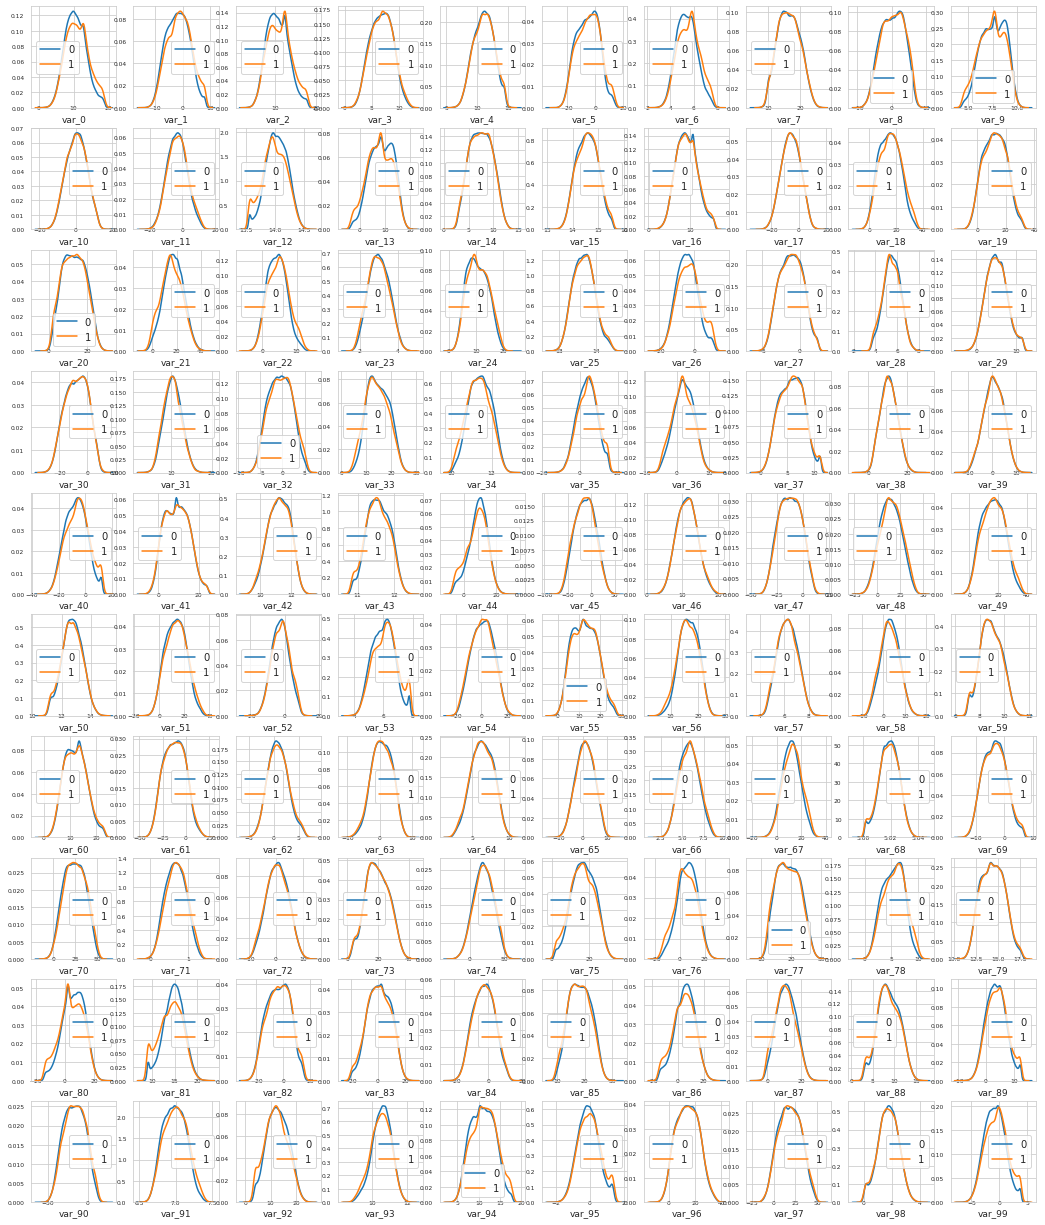

In [ ]:
def plot_feature_distribution(df1, df2, label1, label2, features):
  i = 0
  sns.set_style('whitegrid')
  plt.figure()
  fig, ax = plt.subplots(10, 10, figsize = (18, 22))

  for feature in features:
    i += 1
    plt.subplot(10, 10, i)
    sns.distplot(df1[feature], hist = False, label = label1)
    sns.distplot(df2[feature], hist = False, label = label2)
    plt.xlabel(feature, fontsize = 9)
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'x', which = 'major', labelsize = 6, pad = -6)
    plt.tick_params(axis = 'y', which = 'major', labelsize = 6)


y0 = train[train['target'] == 0]
y1 = train[train['target'] == 1]
feature = train.columns.values[2:102]

plot_feature_distribution(y0, y1, '0', '1', feature)



<Figure size 432x288 with 0 Axes>

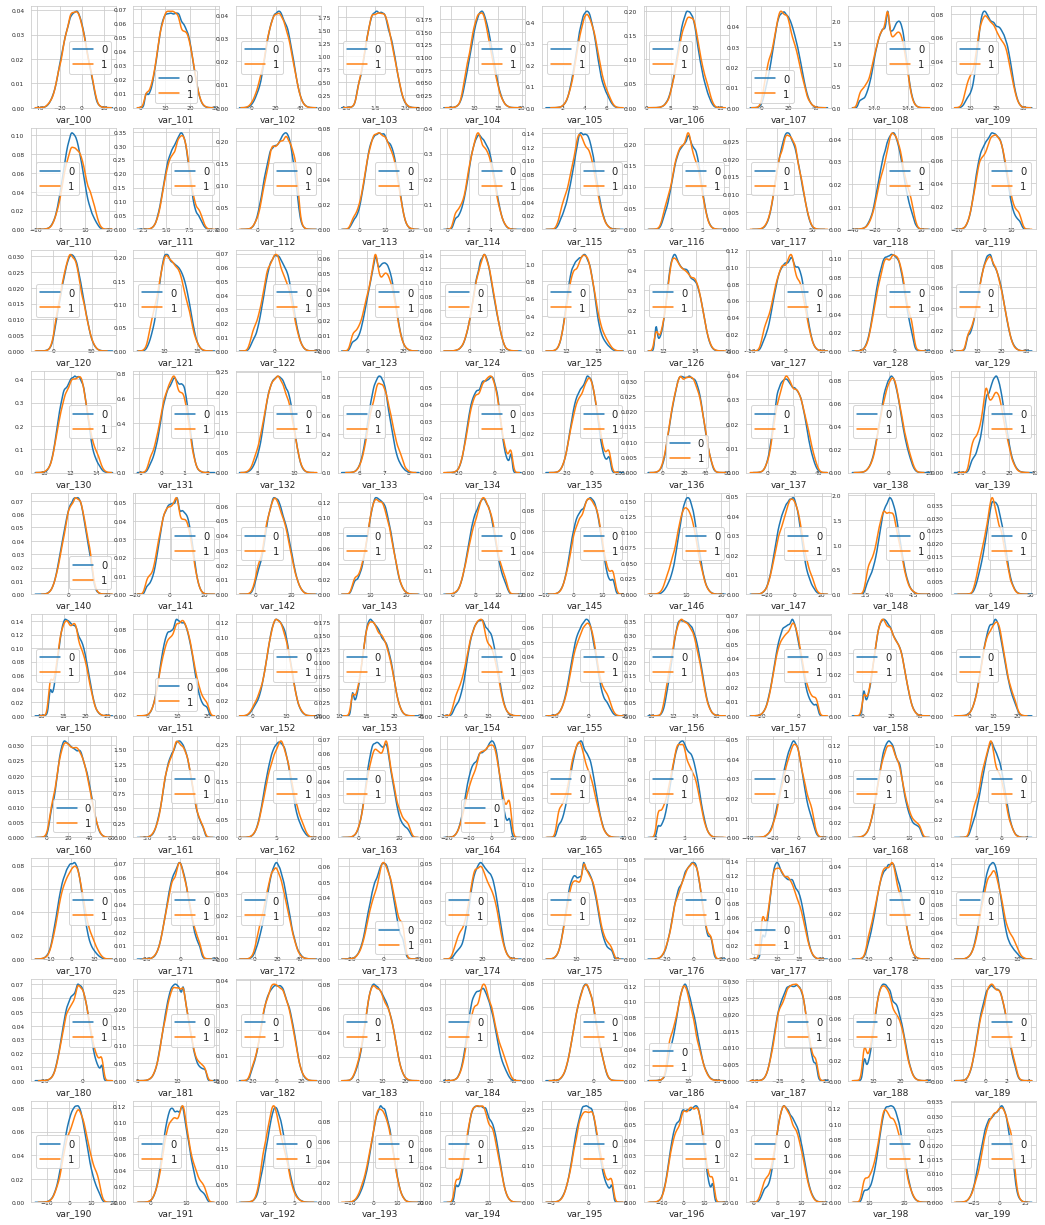

In [ ]:
features = train.columns.values[102:202]
plot_feature_distribution(y0, y1, '0', '1', features)

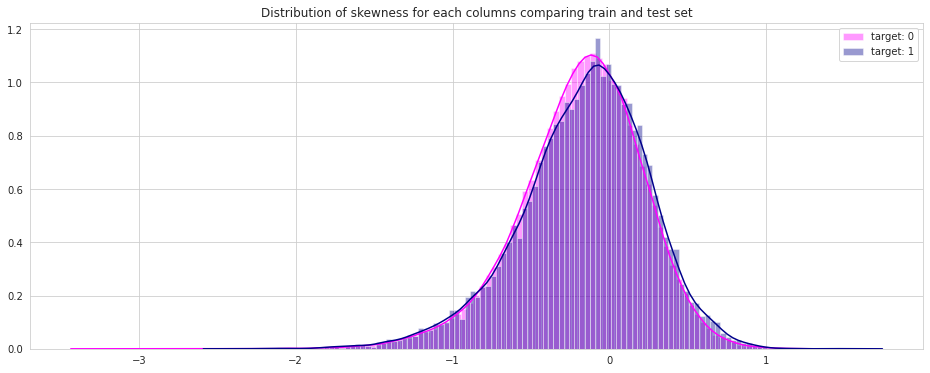

In [ ]:
plt.figure(figsize = (16, 6))
plt.title('Distribution of skewness for each columns comparing train and test set')


features = train.columns.values[2:202]
sns.distplot(y0[features].skew(axis = 1), label = 'target: 0', color = 'magenta', bins = 120)
sns.distplot(y1[features].skew(axis = 1), label = 'target: 1', color = 'darkblue', bins = 120)

plt.legend()

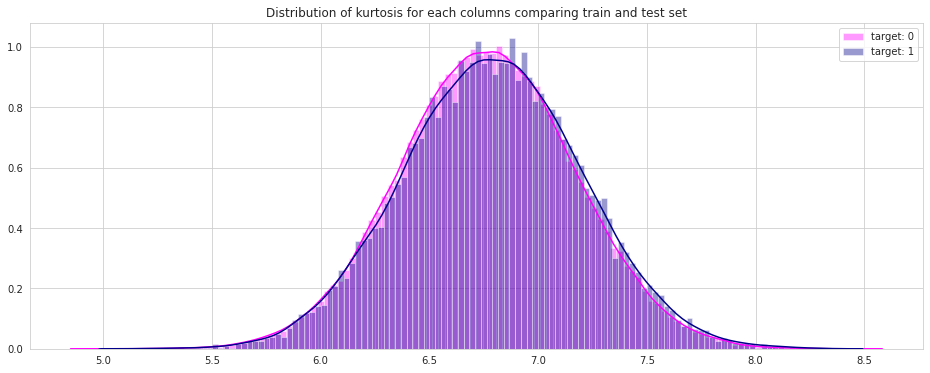

In [ ]:
plt.figure(figsize = (16, 6))
plt.title('Distribution of kurtosis for each columns comparing train and test set')

aggregate_feature = ['min', 'max', 'skew', 'kurtosis', 'mean', 'median', 'sum']

features = train.columns.values[2:202]
sns.distplot(y0[features].mean(axis = 1), label = 'target: 0', color = 'magenta', bins = 120)
sns.distplot(y1[features].mean(axis = 1), label = 'target: 1', color = 'darkblue', bins = 120)

plt.legend()

In [ ]:
# Feature engineering

# Aggregate features: feature that distinguishable in different groups(labels)
col = train.columns.values[2:]
for df in [test, train]:
    df['min'] = df[col].min(axis = 1) # compute aggregate values along each row: we want to create new features based on single sample
    df['max'] = df[col].max(axis = 1)
    df['std'] = df[col].std(axis = 1)
    df['skew'] = df[col].skew(axis = 1)
    df['kurtosis'] = df[col].kurtosis(axis = 1)
    df['sum'] = df[col].sum(axis = 1)
    df['med'] = df[col].median(axis = 1)
    df['mean'] = df[col].mean(axis = 1)

print('Aggregate finished.')



Aggregate finished.


In [ ]:
#Add the round value for the each features

'''
features = [x for x in train.columns if x not in ['ID_code', 'target']]

for feature in features:
  train['r2_' + feature] = np.round(train[feature], 2)
  test['r2_' + feature] = np.round(test[feature], 2)
  train['r1_' + feature] = np.round(train[feature], 1)
  test['r1_' + feature] = np.round(test[feature], 1)

print('Add rounded features.')
'''


Add rounded features.


In [ ]:
# plot feature distribution for these aggregate features
y0 = train[train['target'] == 0]
y1 = train[train['target'] == 1]

features = train.columns.values[202:]
def plot_new_feature(df1, df2, label1, label2, features):
  i = 0
  sns.set_style('whitegrid')
  plt.figure()

  fig, ax = plt.subplots(2, 4, figsize = (18, 8))
  for feature in features:
    i += 1
    plt.subplot(2, 4, i)
    sns.kdeplot(df1[feature], bw = 0.5, label = label1)
    sns.kdeplot(df2[feature], bw = 0.5, label = label2)
    plt.xlabel(feature, fontsize = 11)

    plt.tick_params(axis = 'x', which = 'major', labelsize = 8)
    plt.tick_params(axis = 'y', which = 'major', labelsize = 8)

plot_new_feature(y0, y1, 'target 0', 'target 1', features)





In [ ]:
features = [x for x in train.columns if x not in ['ID_code', 'target']]
target = train['target']
train_df = train[features]

In [ ]:
#@title
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 10, shuffle = False)

# define model

param = {
    'objective':'binary',
    'verbosity':1,
    'metric':'auc',
    'learning_rate':0.01,
    'boost':'gbdt',
    'num_leaves':13,
    'min_data_in_leaf':80,  # prevent over-fitting
    'bagging_freq':5, # bagging different subsample to prevent over fitting
    'bagging_fraction':0.4, # 0.4 proportion of subsamples
    'feature_fraction':0.05,
    'num_threads':2,
    'num_iterations':1000000,
    'boost_from_average':'false',
    'max_depth':-1,
    'min_sum_hessian_in_leaf':10
}

oof = np.zeros(len(train_df))
feature_importance_df = pd.DataFrame() 
predictions = np.zeros(len(test))

for fold_, (train_id, valid_id) in enumerate(kfold.split(train_df, target)):
    print('Fold: ', fold_)
    train_data = lgb.Dataset(train_df.iloc[train_id], target.iloc[train_id])
    valid_data = lgb.Dataset(train_df.iloc[valid_id], target.iloc[valid_id])

    clf = lgb.train(param, train_data, 
                    valid_sets = [train_data, valid_data],
                    verbose_eval = 1000,
                    early_stopping_rounds = 1000
                    )
    # Prediction on out-of-sample prediction on the whole training set
    oof[valid_id] = clf.predict(train_df.iloc[valid_id], num_iterations = clf.best_iteration)

    # save feature importance trained by model
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['Feature Importance'] = clf.feature_importance()
    fold_importance_df['Fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)

    predictions += clf.predict(test[features], num_iteration = clf.best_iteration) \
    / kfold.n_splits

oof_binary = np.round(oof, 0)
print('CV overall score: {:<8.5f}'.format(roc_auc_score(target, oof_binary)))

Fold:  0


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.900594	valid_1's auc: 0.882729
[2000]	training's auc: 0.911279	valid_1's auc: 0.889464
[3000]	training's auc: 0.918945	valid_1's auc: 0.893472
[4000]	training's auc: 0.924795	valid_1's auc: 0.896117
[5000]	training's auc: 0.929732	valid_1's auc: 0.897819
[6000]	training's auc: 0.934048	valid_1's auc: 0.898787
[7000]	training's auc: 0.938079	valid_1's auc: 0.899283
[8000]	training's auc: 0.941739	valid_1's auc: 0.899764
[9000]	training's auc: 0.945277	valid_1's auc: 0.89997
[10000]	training's auc: 0.948597	valid_1's auc: 0.900126
[11000]	training's auc: 0.951815	valid_1's auc: 0.90014
Early stopping, best iteration is:
[10592]	training's auc: 0.95053	valid_1's auc: 0.900207
Fold:  1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.900542	valid_1's auc: 0.883368
[2000]	training's auc: 0.911228	valid_1's auc: 0.88971
[3000]	training's auc: 0.918861	valid_1's auc

KeyboardInterrupt: ignored

In [ ]:
clf.save_model('pretrained_clf', num_iteration = clf.best_iteration)

In [ ]:
files.upload()
clf = lgb.Booster(model_file = 'pretrained_clf')

Saving pretrained_clf to pretrained_clf


In [ ]:
prediction = clf.predict(test.iloc[:, 1:])
#prediction = prediction.round(0).astype(int)
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction
submission.to_csv('submission.csv', index = False)

In [ ]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f submission.csv -m 'late submission'

100% 6.06M/6.06M [00:02<00:00, 2.86MB/s]
Successfully submitted to Santander Customer Transaction Prediction

In [ ]:
from google.colab import files

files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle competitions download -c competitive-data-science-predict-future-sales

Saving kaggle.json to kaggle.json
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 5.06MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 64.0MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.54MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 52.1MB/s]
 68% 9.00M/13.3M [00:00<00:00, 23.4MB/s]
100% 13.3M/13.3M [00:00<00:00, 33.5MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 135MB/s]
